# Selecting Optimal Temperature Columns



In [1]:
from src import utils
from src.modelling import training, transforms
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt

proj_root = utils.get_proj_root()
config = utils.get_config('config/config.ini')
preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])
preprocessed_data= training.get_training_data(file_path=preprocessed_data_path)


In [2]:


def make_pipeline(temperature_columns_to_drop=None):

    # categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'datetime'] #+ temperature_columns_to_drop

    pipeline = Pipeline(
            steps=[
                # ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                #                                             new_column_name='is_weekend', 
                #                                             derive_func=transforms.is_weekend)
                #                                             ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                # ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                #                                             new_column_name='is_holiday', 
                #                                             derive_func=transforms.is_holiday)
                #                                             ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                # ("create_hour_sin",transforms.DerivedColumnTransformer(column_name='hour', 
                #                                             new_column_name='hour_sin', 
                #                                             derive_func=transforms.time_sin_transform,
                #                                             func_kwargs={'period':24})
                #                                             ),
                # ("create_hour_cos",transforms.DerivedColumnTransformer(column_name='hour', 
                #                                             new_column_name='hour_cos', 
                #                                             derive_func=transforms.time_cos_transform,
                #                                             func_kwargs={'period':24})
                #                                             ),
                # ("create_month_sin",transforms.DerivedColumnTransformer(column_name='month', 
                #                                             new_column_name='month_sin', 
                #                                             derive_func=transforms.time_sin_transform,
                #                                             func_kwargs={'period':12})
                #                                             ),
                # ("create_month_cos",transforms.DerivedColumnTransformer(column_name='month', 
                #                                             new_column_name='month_cos', 
                #                                             derive_func=transforms.time_cos_transform,
                #                                             func_kwargs={'period':12})
                #                                             ),
                # ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

temperature_pipeline = make_pipeline()


In [3]:
temp_df = temperature_pipeline.fit_transform(preprocessed_data)
training_data, testing_data = train_test_split(temp_df, test_size=0.3, shuffle=False)

label_col_name = 'load'
X_train, y_trbain = training.split_Xy(training_data, label_col_name=label_col_name)
X_test, y_test = training.split_Xy(testing_data, label_col_name=label_col_name)

## get feature importance

In [21]:


randomForestModel = RandomForestRegressor(max_features=None)  # We want all features to be considered for each tree

randomForestModel.fit(X_train, y_train)
model_importance = randomForestModel.feature_importances_
importance_table = pd.DataFrame(columns=["Feature", "Importance"])  # Create an importance table to plot bar chart
featureNum = 0
for score in model_importance:
    # print("feature " + str(featureNum) + "'s importance score: " + str(score) + " (" + X_train.columns[featureNum] + ")")
    rowAdded = pd.DataFrame([[X_train.columns[featureNum], score]], columns=["Feature", "Importance"])
    importance_table = pd.concat([importance_table, rowAdded])
    featureNum = featureNum + 1
importance_table_sorted =  importance_table.sort_values('Importance', ascending=False).reset_index(drop=True)



/tmp/ipykernel_11222/27345472.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  importance_table = pd.concat([importance_table, rowAdded])


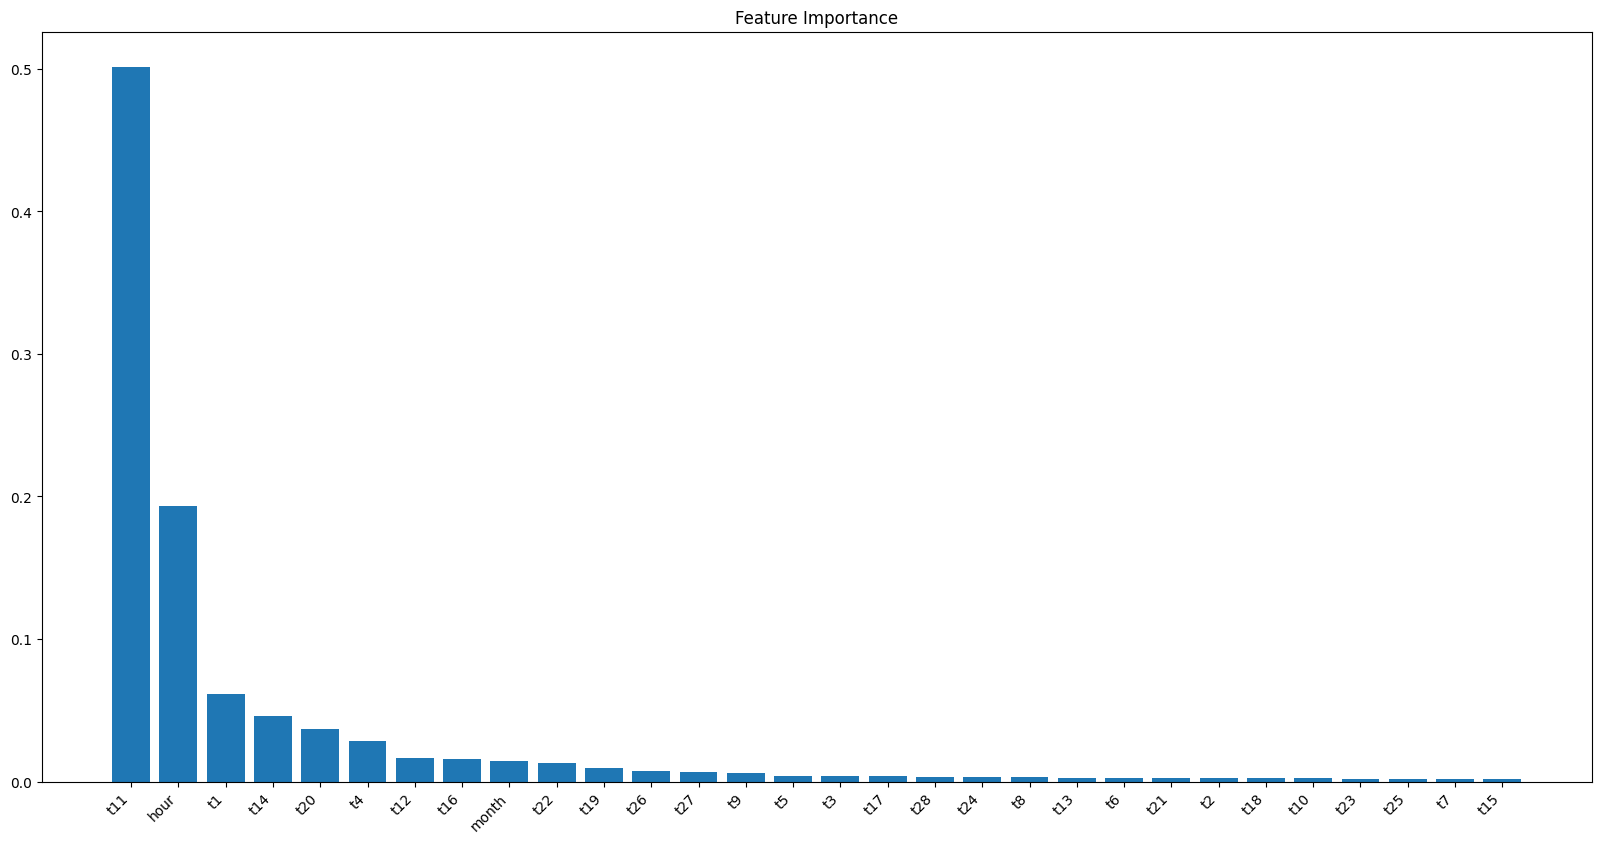

In [22]:
importance_table_sorted =  importance_table.sort_values('Importance', ascending=False).reset_index(drop=True)
importance_table_sorted

# Plot a bar chart to visualize feature importance
plt.figure(figsize=(20, 10))
# sns.barplot(data=importance_table, x="Feature", y="Importance")
plt.bar(importance_table_sorted['Feature'], importance_table_sorted['Importance'])
plt.title("Feature Importance")
plt.subplots_adjust(bottom=0.2, top=0.95)
plt.xticks(rotation=45, ha='right')
plt.show()

## Get feature subset

In [23]:
X_train_temp = X_train.copy()
X_test_temp = X_test.copy()

# Initialize the result dataframe
result_df = pd.DataFrame(columns=['Features_Removed', 'score'])

# First, evaluate performance using all features
randomForestModel = RandomForestRegressor(max_features=None)
randomForestModel.fit(X_train_temp, y_train)
# Predict probabilities on test data
y_pred = randomForestModel.predict(X_test_temp)
# Compute ROC score
score = mean_absolute_percentage_error(y_test, y_pred)
# Append the initial result to the result dataframe
new_row = pd.DataFrame({'Features_Removed': ['None'], 'score': [score]})
result_df = pd.concat([result_df, new_row])
# result_df = result_df.append({'Features_Removed': 'None', 'ROC_Score': roc_score}, ignore_index=True)
print(f"Feature_Removed: None, Number of features used: {len(X_train_temp.columns)}, score: {score}")

# Sort importance_table by Importance in ascending order to start with the least important
importance_table_sorted_asc = importance_table.sort_values('Importance', ascending=True)

# Loop through features, starting from the least important
for index, row in importance_table_sorted_asc.iterrows():
    # Drop the feature from training and test data
    X_train_temp = X_train_temp.drop(columns=[row['Feature']])
    X_test_temp = X_test_temp.drop(columns=[row['Feature']])
    # Train a random forest model
    randomForestModel = RandomForestRegressor(max_features=None)
    randomForestModel.fit(X_train_temp, y_train)
    # Predict probabilities on test data
    y_pred = randomForestModel.predict(X_test_temp)
    # Compute ROC score
    score = mean_absolute_percentage_error(y_test, y_pred)
    # Append the result to the result dataframe
    new_row = pd.DataFrame({'Features_Removed': [row['Feature']], 'score': [score]})
    result_df = pd.concat([result_df, new_row])
    # result_df = result_df.append({'Features_Removed': row['Feature'], 'ROC_Score': roc_score}, ignore_index=True)
    print(
        f"Feature_Removed: {row['Feature']}, Number of features used: {len(X_train_temp.columns)}, score: {score}")
    # If only one feature left, break the loop
    if X_train_temp.shape[1] == 1:
        break

/tmp/ipykernel_11222/2615050622.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, new_row])


Feature_Removed: None, Number of features used: 30, score: 0.08590521434640405
Feature_Removed: t15, Number of features used: 29, score: 0.0857931481169156
Feature_Removed: t7, Number of features used: 28, score: 0.08583434199472989
Feature_Removed: t25, Number of features used: 27, score: 0.08576399578326648
Feature_Removed: t23, Number of features used: 26, score: 0.08606157658297935
Feature_Removed: t10, Number of features used: 25, score: 0.08568206223280216
Feature_Removed: t18, Number of features used: 24, score: 0.08568305719600976
Feature_Removed: t2, Number of features used: 23, score: 0.08463158281697039
Feature_Removed: t21, Number of features used: 22, score: 0.08507762447238054
Feature_Removed: t6, Number of features used: 21, score: 0.08494762434209419
Feature_Removed: t13, Number of features used: 20, score: 0.08500729407742981
Feature_Removed: t8, Number of features used: 19, score: 0.08546226298587953
Feature_Removed: t24, Number of features used: 18, score: 0.08550847

In [27]:
result_df.sort_values(by='score').head()

,Features_Removed,score
0,t22,0.082547
0,t2,0.084632
0,t9,0.084799
0,t6,0.084948
0,t5,0.084995


In [44]:
feature_removed_before_best = result_df.iloc[result_df['score'].argmin(), :]['Features_Removed']
print(feature_removed_before_best)

feature_rank_thresh = importance_table_sorted.index[importance_table_sorted['Feature'] == feature_removed_before_best][0]
print(feature_rank_thresh)


best_features = list(importance_table_sorted[importance_table_sorted.index < feature_rank_thresh]['Feature'].values)
print(best_features)


temperature_column_names = list(training_data.columns[1:29])
print(temperature_column_names)

optimal_temperature_column_names = [column_name for column_name in best_features if column_name in temperature_column_names]


temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
utils.save_value(temperature_column_names, fname=temperature_column_names_path)

optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
utils.save_value(optimal_temperature_column_names, fname=optimal_temperature_column_names_path)

t22
9
['t11', 'hour', 't1', 't14', 't20', 't4', 't12', 't16', 'month']
['t2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15', 't16', 't17', 't18', 't19', 't20', 't21', 't22', 't23', 't24', 't25', 't26', 't27', 't28']
